In [ ]:
#loading json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fowaad","key":"dffc6e38cb97f3f108aeaca120a0cc8f"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Jul 26 15:21 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 744M/745M [00:19<00:00, 56.8MB/s]
100% 745M/745M [00:19<00:00, 39.7MB/s]


In [ ]:
!unzip covid19-radiography-database.zip -d covid19-radiography-database

Streaming output truncated to the last 5000 lines.
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-

Importing libraries

In [ ]:
import numpy as np
!pip install fastai
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     |████████████████████████████████| 720 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.3 MB/s 
     |████████████████████████████████| 188 kB 47.9 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 51 kB 318 kB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
from fastai.vision.all import *

In [ ]:
path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'

Setting up datablock

In [ ]:
#Selecting images and separating them into categories using image and category block.
#Procuring images from the directory using get_items
#labelling them using get_y
#Splitting the images, transforming them to 224 pixels, as well as using image augmentations.
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=4),
   item_tfms=RandomResizedCrop(224, min_scale=0.3),
   batch_tfms=aug_transforms())

In [ ]:
#Dataloaders breaks up the data batch sizes as well as training and validation data.

dataloaders = db.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


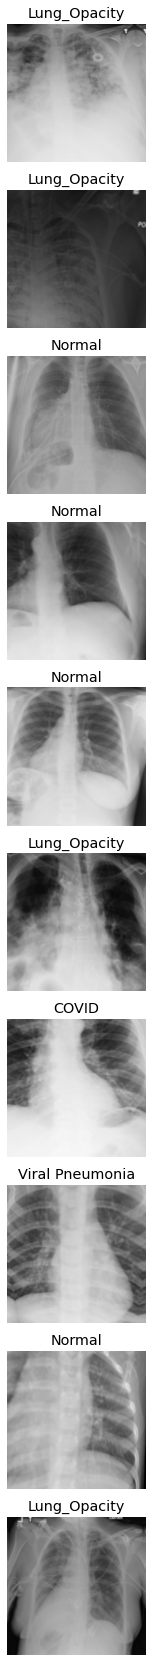

In [ ]:
#Now that dataloaders has been used we can visualize the dataset to ensure correct images
dataloaders.show_batch(max_n=10, nrows=10)

In [ ]:
#looking for image files that were incorrectly downloaded
verify = verify_images(get_image_files(path))

In [ ]:
verify

(#0) []

In [ ]:
# defining a learner using a pretrained model
learn = cnn_learner(dataloaders,resnet34, metrics=error_rate)



Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


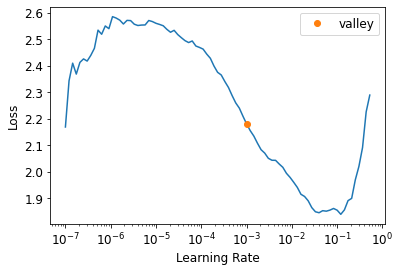

In [ ]:
#finding the best learning rate
lr_min = learn.lr_find()

In [ ]:
#running the data on the model for a few epochs for testing
epochs=3
learn.fit_one_cycle(epochs, lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,0.618720,0.810035,0.241200,10:37
1,0.361212,0.379925,0.138200,10:38


epoch,train_loss,valid_loss,error_rate,time
0,0.618720,0.810035,0.241200,10:37
1,0.361212,0.379925,0.138200,10:38
2,0.311827,0.352416,0.127333,10:38


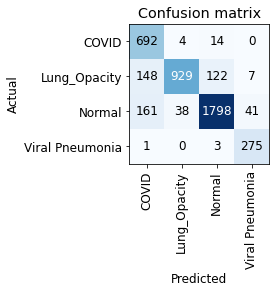

In [ ]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# predictions with maximum loss
interp.plot_top_losses(5, nrows=5)

In [ ]:
#unfreeze the pretrained networks to train their parameters to the new dataset
learn.unfreeze()


SuggestedLRs(valley=6.918309736647643e-06)

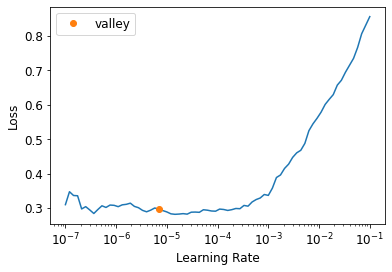

In [ ]:
#finding new learning rate, as now we will be training all the layers as opposed to just the head that we did previously
learn.lr_find()

In [ ]:
#Using discriminative learning rates for more accurate training to account for the differences in the
#complexity of features learned by the model at different layers. We will retrain the model again to accomplish this

learn = cnn_learner(dataloaders, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, lr_min)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(2e-6,3e-4)) #2e-6 is the learning rate for the earlier layers as they require less training
                                                 #3e-4 is the learning rate for the later layers as they require greater adjustment
                                                 #of weights for they learn complex features


epoch,train_loss,valid_loss,error_rate,time
0,0.765812,0.484198,0.145760,04:24
1,0.461577,0.410106,0.143161,04:23
2,0.426849,0.382243,0.132766,04:24


epoch,train_loss,valid_loss,error_rate,time
0,0.407223,0.388923,0.136074,06:03
1,0.372856,0.355463,0.125443,06:01
2,0.327807,0.273159,0.091425,06:01
3,0.292852,0.362007,0.139145,06:01
4,0.258542,0.250719,0.086464,06:00
5,0.248043,0.258945,0.093551,06:00


epoch,train_loss,valid_loss,error_rate,time
0,0.407223,0.388923,0.136074,06:03
1,0.372856,0.355463,0.125443,06:01
2,0.327807,0.273159,0.091425,06:01
3,0.292852,0.362007,0.139145,06:01
4,0.258542,0.250719,0.086464,06:00
5,0.248043,0.258945,0.093551,06:00
6,0.220021,0.206058,0.072053,06:00
7,0.221783,0.195665,0.068273,06:00
8,0.215649,0.198873,0.072998,06:00
9,0.185307,0.213396,0.075833,06:00


The model training stopped as GPU limit was reached in colab. However the error rate didnt change much in the last 5 epochs indicating the need to train using a more powerful model for better results.

In [ ]:
#Using discriminative learning rates for more accurate training to account for the differences in the
#complexity of features learned by the model at different layers. We will retrain the model again to accomplish this

learn = cnn_learner(dataloaders, resnet50, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


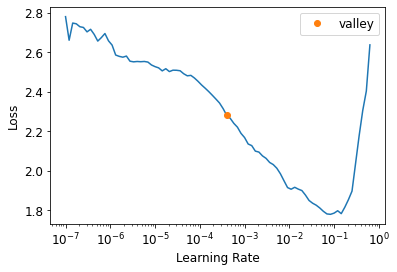

In [ ]:
#best learning rate for the model with pretrained portion frozen
lr_min = learn.lr_find()

In [ ]:
#unfreezing the pretrained model to find the best learning rate for the entire system
learn.unfreeze()


SuggestedLRs(valley=0.0012022644514217973)

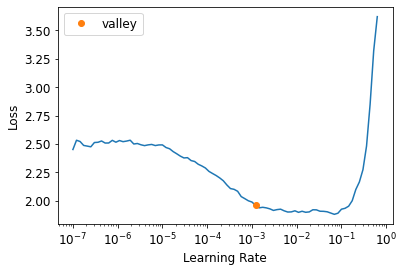

In [ ]:
learn.lr_find()

In [ ]:
#training the new model

learn = cnn_learner(dataloaders, resnet50, metrics=error_rate)
learn.fit_one_cycle(3, lr_min)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-3,1e-4)) #1e-5 is the learning rate for the earlier layers as they require less training
                                                 #6e-3 is the learning rate for the later layers as they require greater adjustment
                                                 #of weights for they learn complex features

epoch,train_loss,valid_loss,error_rate,time
0,0.859081,0.508313,0.154500,06:49
1,0.552234,0.443824,0.141035,06:49
2,0.456283,0.374961,0.123553,06:48


epoch,train_loss,valid_loss,error_rate,time
0,0.461959,0.381233,0.128750,08:51
1,0.502512,0.675656,0.235058,08:51


epoch,train_loss,valid_loss,error_rate,time
0,0.461959,0.381233,0.128750,08:51
1,0.502512,0.675656,0.235058,08:51
2,0.492681,0.417214,0.142452,08:51
3,0.422148,1.091569,0.309709,08:51
4,0.381660,0.437772,0.152847,08:51
5,0.342268,0.261450,0.094259,08:52
6,0.298889,0.270212,0.106308,08:51
7,0.242699,0.232442,0.082211,08:51
8,0.213959,0.185575,0.066619,08:51
9,0.195938,0.146295,0.048193,08:51


Saving the model

In [ ]:

learn.save('resnet50_3,12E_1e-3,1e-4Lr_model')

Path('models/resnet50_3,12E_1e-3,1e-4Lr_model.pth')

In [ ]:
learn.export()

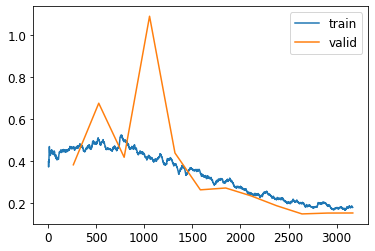

In [ ]:
#Visualizing the plot loss
learn.recorder.plot_loss()

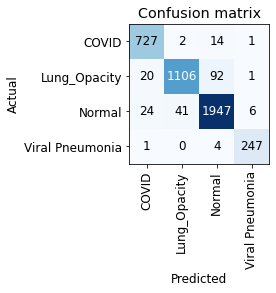

In [ ]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#testing a random COVID xray downloaded from google images
learn.predict('/content/gdrive/MyDrive/fx1_lrg.jpg')

('COVID', tensor(0), tensor([9.9662e-01, 1.9548e-03, 1.0116e-03, 4.0896e-04]))